# Assignment 6 — Build and Evaluate Tree Models (ISLR Python)

**Dataset:** Multi-class Prediction of Obesity Risk (Kaggle-style train/test split)

This notebook addresses:

1. **Conceptual Q1 (ISLR Python, p. 363):** Example of a 2D feature-space partition produced by *recursive binary splitting*, with labeled regions **R1–R6** and cutpoints **t1, t2, …**, plus the corresponding decision tree.
2. **Applied Q12 (ISLR Python, p. 366):** Fit and evaluate **bagging**, **random forests**, **boosting**, and (where feasible) **BART**, and compare to a simple baseline (multinomial logistic regression).
3. **Competition requirement:** Train four classification models (**decision tree**, **bagged**, **random forest**, **boosted**) and export **four submission CSVs**.

> **Paths:** `/mnt/data/train.csv`, `/mnt/data/test.csv`


In [1]:
# If running locally, ensure you have these installed:
# pip install numpy pandas scikit-learn matplotlib

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, HistGradientBoostingClassifier

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# Load data
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

train.head(), test.head()

print("Train:", train.shape)
print("Test :", test.shape)
display(train.head())


Train: (20758, 18)
Test : (13840, 17)


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
# Separate features/target
TARGET = "NObeyesdad"
ID_COL = "id"

X = train.drop(columns=[TARGET])
y = train[TARGET].astype(str)  # ensure consistent string labels

X_test = test.copy()

# Identify numeric vs categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_cols, categorical_cols


(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'],
 ['Gender',
  'family_history_with_overweight',
  'FAVC',
  'CAEC',
  'SMOKE',
  'SCC',
  'CALC',
  'MTRANS'])

In [4]:
# Quick data checks
print("Missing values (train):")
display(train.isna().sum().sort_values(ascending=False).head(10))

print("\nClass distribution:")
class_counts = y.value_counts()
display(class_counts)
print("\nClass proportions:")
display((class_counts / class_counts.sum()).round(4))


Missing values (train):


id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
dtype: int64


Class distribution:


NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64


Class proportions:


NObeyesdad
Obesity_Type_III       0.1949
Obesity_Type_II        0.1565
Normal_Weight          0.1485
Obesity_Type_I         0.1402
Insufficient_Weight    0.1215
Overweight_Level_II    0.1215
Overweight_Level_I     0.1169
Name: count, dtype: float64

In [5]:
# Preprocessing: impute (if needed) + one-hot encode categoricals
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)


In [6]:
# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train split:", X_train.shape, " Valid split:", X_valid.shape)


Train split: (16606, 17)  Valid split: (4152, 17)


## Models

We fit the following models:

- **Baseline:** Multinomial logistic regression (simple linear classifier)
- **Decision Tree:** `DecisionTreeClassifier`
- **Bagging:** `BaggingClassifier` with decision trees as base estimators
- **Random Forest:** `RandomForestClassifier`
- **Boosting:** `HistGradientBoostingClassifier` (gradient boosting on decision trees, efficient for tabular data)

Evaluation metrics:
- **Accuracy**
- **Macro F1** (balances performance across classes)



In [7]:
def evaluate_model(name, pipe):
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    f1m = f1_score(y_valid, preds, average="macro")
    print(f"{name}: accuracy={acc:.4f} | macro_f1={f1m:.4f}")
    return {
        "model": name,
        "accuracy": acc,
        "macro_f1": f1m,
        "estimator": pipe
    }

results = []


In [8]:
# Baseline: multinomial logistic regression
logit = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=5000, multi_class="multinomial", n_jobs=None))
])

results.append(evaluate_model("Multinomial Logistic Regression", logit)
)


C:\Users\dillo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Multinomial Logistic Regression: accuracy=0.7030 | macro_f1=0.6717


C:\Users\dillo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
# Decision Tree (tune lightly to reduce overfitting)
dtree = Pipeline(steps=[
    ("prep", preprocess),
    ("model", DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=10,
        min_samples_leaf=10
    ))
])

results.append(evaluate_model("Decision Tree", dtree))


Decision Tree: accuracy=0.8784 | macro_f1=0.8655


In [10]:
# Bagging (bootstrap aggregating) over trees
bag = Pipeline(steps=[
    ("prep", preprocess),
    ("model", BaggingClassifier(
        estimator=DecisionTreeClassifier(
            random_state=RANDOM_STATE,
            max_depth=None,
            min_samples_leaf=2
        ),
        n_estimators=300,
        bootstrap=True,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

results.append(evaluate_model("Bagging (Trees)", bag))


Bagging (Trees): accuracy=0.8972 | macro_f1=0.8861


In [11]:
# Random Forest
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=600,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        max_depth=None,
        min_samples_leaf=1,
        class_weight=None
    ))
])

results.append(evaluate_model("Random Forest", rf))


Random Forest: accuracy=0.8957 | macro_f1=0.8841


In [12]:
# Boosting (Gradient boosting over trees)
hgb = Pipeline(steps=[
    ("prep", preprocess),
    ("model", HistGradientBoostingClassifier(
        learning_rate=0.08,
        max_depth=6,
        max_iter=350,
        random_state=RANDOM_STATE
    ))
])

results.append(evaluate_model("Boosting (HistGradientBoosting)", hgb))


Boosting (HistGradientBoosting): accuracy=0.9085 | macro_f1=0.8987


In [13]:
# Summary table
summary = pd.DataFrame(results)[["model", "accuracy", "macro_f1"]].sort_values(
    by=["macro_f1", "accuracy"], ascending=False
).reset_index(drop=True)
display(summary)


,model,accuracy,macro_f1
0,Boosting (HistGradientBoosting),0.908478,0.898687
1,Bagging (Trees),0.897158,0.886124
2,Random Forest,0.895713,0.884070
3,Decision Tree,0.878372,0.865523
4,Multinomial Logistic Regression,0.703035,0.671667


Boosting (HistGradientBoosting)
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.95      0.94       505
      Normal_Weight       0.89      0.88      0.88       617
     Obesity_Type_I       0.89      0.89      0.89       582
    Obesity_Type_II       0.97      0.97      0.97       650
   Obesity_Type_III       1.00      1.00      1.00       809
 Overweight_Level_I       0.83      0.78      0.80       485
Overweight_Level_II       0.80      0.82      0.81       504

           accuracy                           0.91      4152
          macro avg       0.90      0.90      0.90      4152
       weighted avg       0.91      0.91      0.91      4152



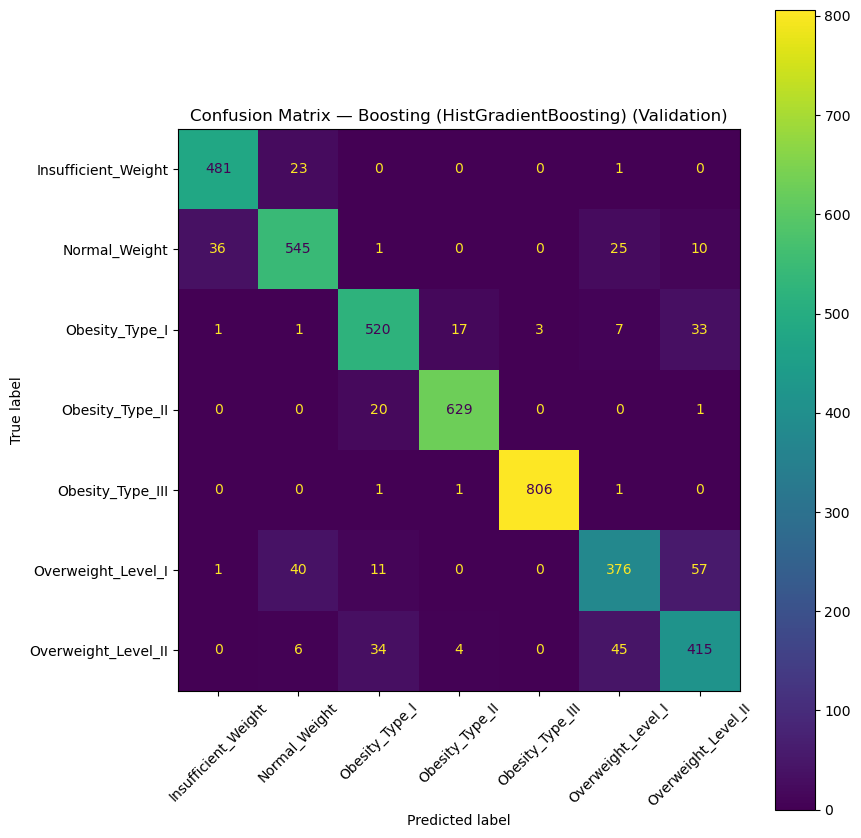

In [14]:
# Confusion matrix for the best validation model (by macro F1)
best_row = summary.iloc[0]
best_name = best_row["model"]
best_est = [r["estimator"] for r in results if r["model"] == best_name][0]

best_preds = best_est.predict(X_valid)

print(best_name)
print(classification_report(y_valid, best_preds))

fig, ax = plt.subplots(figsize=(9, 9))
ConfusionMatrixDisplay.from_predictions(
    y_valid, best_preds, xticks_rotation=45, ax=ax, normalize=None
)
plt.title(f"Confusion Matrix — {best_name} (Validation)")
plt.tight_layout()
plt.show()


## Assumption / Diagnostics Checks (Tree Ensembles)

Tree-based models are nonparametric and do not require linearity or normal residual assumptions. The main practical risks are:

- **Overfitting** (especially a single deep decision tree)
- **Class imbalance** affecting minority-class recall
- **High variance** in unstable learners (mitigated by bagging/RF)
- **Hyperparameter sensitivity** (depth, learning rate, number of trees)

Below we run a small cross-validated check to confirm the validation ranking is stable.


In [15]:
# Cross-validated macro F1 for each model (quick diagnostic)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_macro_f1(pipe):
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
    return scores.mean(), scores.std()

cv_rows = []
for r in results:
    mean_f1, std_f1 = cv_macro_f1(r["estimator"])
    cv_rows.append({"model": r["model"], "cv_macro_f1_mean": mean_f1, "cv_macro_f1_std": std_f1})

cv_summary = pd.DataFrame(cv_rows).sort_values("cv_macro_f1_mean", ascending=False).reset_index(drop=True)
display(cv_summary)


,model,cv_macro_f1_mean,cv_macro_f1_std
0,Boosting (HistGradientBoosting),0.894208,0.003625
1,Bagging (Trees),0.884045,0.004816
2,Random Forest,0.881551,0.004838
3,Decision Tree,0.863808,0.004509
4,Multinomial Logistic Regression,0.679659,0.010428


## Kaggle-Style Submissions (4 required models)

We refit each of the four required models on the **full training data**, predict labels for `test.csv`, and write:

- `submission_decision_tree.csv`
- `submission_bagging.csv`
- `submission_random_forest.csv`
- `submission_boosting.csv`


In [16]:
# Refit required models on the full training data and write Kaggle submission CSVs.
# Output files:
#   - submission_decision_tree.csv
#   - submission_bagging.csv
#   - submission_random_forest.csv
#   - submission_boosting.csv

from pathlib import Path

def make_submission(pipe, filename):
    """Fit pipeline on full training data and write Kaggle submission CSV."""
    pipe.fit(X, y)
    test_preds = pipe.predict(X_test)

    sub = pd.DataFrame({
        ID_COL: X_test[ID_COL].values,
        TARGET: test_preds
    })

    out_path = Path(filename)
    sub.to_csv(out_path, index=False)
    return sub.head(), str(out_path.resolve())

sub_outputs = []

# Decision Tree
head_dt, f_dt = make_submission(dtree, "submission_decision_tree.csv")
sub_outputs.append(("Decision Tree", f_dt, head_dt))

# Bagging
head_bag, f_bag = make_submission(bag, "submission_bagging.csv")
sub_outputs.append(("Bagging", f_bag, head_bag))

# Random Forest
head_rf, f_rf = make_submission(rf, "submission_random_forest.csv")
sub_outputs.append(("Random Forest", f_rf, head_rf))

# Boosting
head_boost, f_boost = make_submission(hgb, "submission_boosting.csv")
sub_outputs.append(("Boosting", f_boost, head_boost))

sub_outputs


[('Decision Tree',
  'C:\\Users\\dillo\\Downloads\\Predictive Analysis\\submission_decision_tree.csv',
        id          NObeyesdad
  0  20758     Obesity_Type_II
  1  20759  Overweight_Level_I
  2  20760    Obesity_Type_III
  3  20761      Obesity_Type_I
  4  20762    Obesity_Type_III),
 ('Bagging',
  'C:\\Users\\dillo\\Downloads\\Predictive Analysis\\submission_bagging.csv',
        id          NObeyesdad
  0  20758     Obesity_Type_II
  1  20759  Overweight_Level_I
  2  20760    Obesity_Type_III
  3  20761      Obesity_Type_I
  4  20762    Obesity_Type_III),
 ('Random Forest',
  'C:\\Users\\dillo\\Downloads\\Predictive Analysis\\submission_random_forest.csv',
        id          NObeyesdad
  0  20758     Obesity_Type_II
  1  20759  Overweight_Level_I
  2  20760    Obesity_Type_III
  3  20761      Obesity_Type_I
  4  20762    Obesity_Type_III),
 ('Boosting',
  'C:\\Users\\dillo\\Downloads\\Predictive Analysis\\submission_boosting.csv',
        id          NObeyesdad
  0  20758     

## Conceptual Q1 (Recursive Binary Splitting): Example Partition + Tree

Below is an invented 2D feature space with features **X1** and **X2** and cutpoints:

- **t1 = 2.5** (vertical split on X1)
- In the right branch: **t2 = 4.0** (horizontal split on X2)
- In the left branch: **t3 = 3.0** (horizontal split on X2)
- Additional splits to reach **≥ 6 regions**:
  - In region (X1 < t1 and X2 < t3): **t4 = 1.2** (vertical split on X1)
  - In region (X1 ≥ t1 and X2 ≥ t2): **t5 = 6.0** (vertical split on X1)

This yields **six labeled regions**: **R1–R6**.

The companion tree diagram matches the same splitting rules.


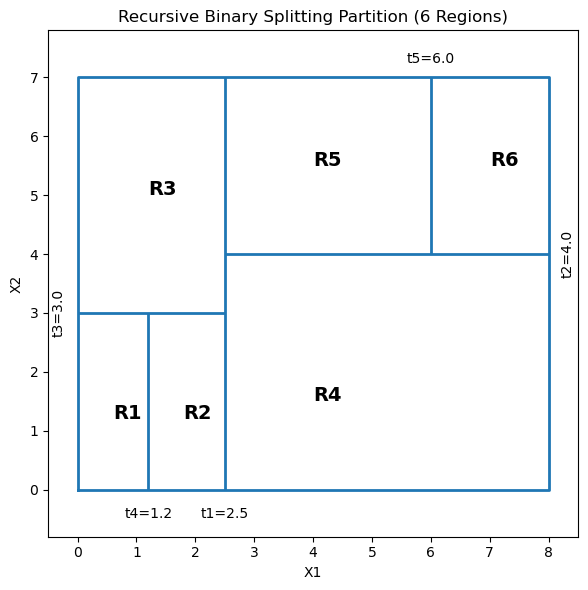

In [17]:
# Draw partition of 2D space with labeled regions and cutpoints
t1, t2, t3, t4, t5 = 2.5, 4.0, 3.0, 1.2, 6.0

x_min, x_max = 0.0, 8.0
y_min, y_max = 0.0, 7.0

fig, ax = plt.subplots(figsize=(8, 6))

# Outer box
ax.plot([x_min, x_max, x_max, x_min, x_min],
        [y_min, y_min, y_max, y_max, y_min], linewidth=2)

# Splits
# t1: vertical across full height
ax.vlines(t1, y_min, y_max, linewidth=2)
# Left branch split t3: horizontal only on left side
ax.hlines(t3, x_min, t1, linewidth=2)
# Right branch split t2: horizontal only on right side
ax.hlines(t2, t1, x_max, linewidth=2)
# Additional split t4: vertical only in bottom-left block (x < t1 and y < t3)
ax.vlines(t4, y_min, t3, linewidth=2)
# Additional split t5: vertical only in top-right block (x >= t1 and y >= t2)
ax.vlines(t5, t2, y_max, linewidth=2)

# Cutpoint labels
ax.text(t1, y_min-0.3, "t1=2.5", ha="center", va="top")
ax.text(x_min-0.2, t3, "t3=3.0", ha="right", va="center", rotation=90)
ax.text(x_max+0.2, t2, "t2=4.0", ha="left", va="center", rotation=90)
ax.text(t4, y_min-0.3, "t4=1.2", ha="center", va="top")
ax.text(t5, y_max+0.2, "t5=6.0", ha="center", va="bottom")

# Region labels (place roughly in region centers)
ax.text(0.6, 1.2, "R1", fontsize=14, weight="bold")
ax.text(1.8, 1.2, "R2", fontsize=14, weight="bold")
ax.text(1.2, 5.0, "R3", fontsize=14, weight="bold")
ax.text(4.0, 1.5, "R4", fontsize=14, weight="bold")
ax.text(4.0, 5.5, "R5", fontsize=14, weight="bold")
ax.text(7.0, 5.5, "R6", fontsize=14, weight="bold")

ax.set_xlim(x_min-0.5, x_max+0.5)
ax.set_ylim(y_min-0.8, y_max+0.8)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title("Recursive Binary Splitting Partition (6 Regions)")
ax.set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()


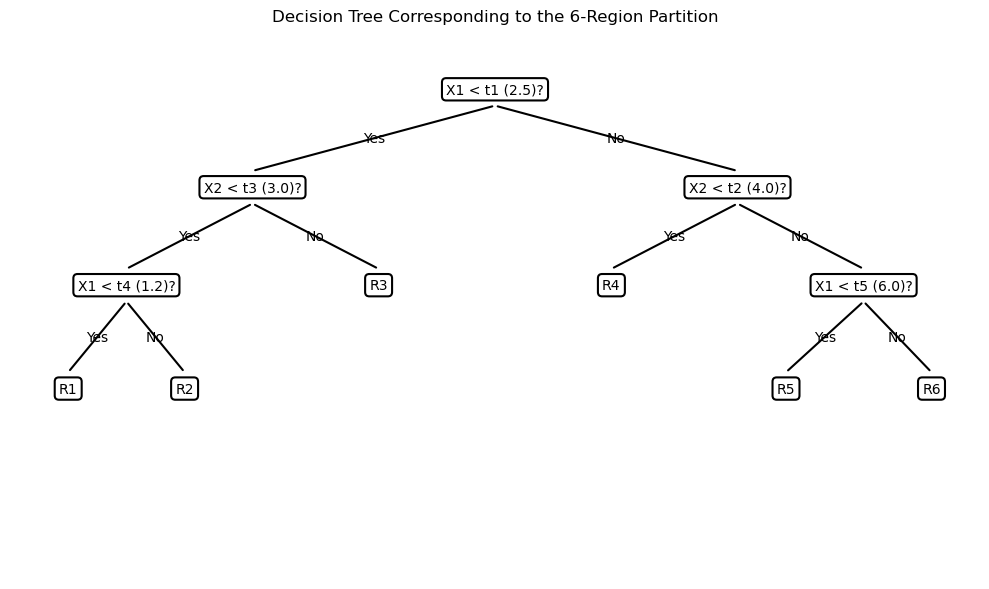

In [18]:
# Draw the corresponding decision tree (simple matplotlib annotation diagram)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Node positions (x,y in axes fraction coordinates)
nodes = {
    "root": (0.5, 0.90),
    "L1": (0.25, 0.72),
    "R1": (0.75, 0.72),
    "LL": (0.12, 0.54),
    "LR": (0.38, 0.54),
    "RL": (0.62, 0.54),
    "RR": (0.88, 0.54),
    "LLL": (0.06, 0.35),
    "LLR": (0.18, 0.35),
    "RR_L": (0.80, 0.35),
    "RR_R": (0.95, 0.35),
}

def draw_box(label, xy):
    ax.text(xy[0], xy[1], label, ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1.5))

def draw_edge(a, b, text=None):
    xa, ya = nodes[a]
    xb, yb = nodes[b]
    ax.annotate("", xy=(xb, yb+0.03), xytext=(xa, ya-0.03),
                arrowprops=dict(arrowstyle="-", lw=1.5))
    if text:
        ax.text((xa+xb)/2, (ya+yb)/2, text, ha="center", va="center", fontsize=10)

# Draw boxes
draw_box("X1 < t1 (2.5)?", nodes["root"])
draw_box("X2 < t3 (3.0)?", nodes["L1"])
draw_box("X2 < t2 (4.0)?", nodes["R1"])
draw_box("X1 < t4 (1.2)?", nodes["LL"])
draw_box("R3", nodes["LR"])     # leaf
draw_box("R4", nodes["RL"])     # leaf
draw_box("X1 < t5 (6.0)?", nodes["RR"])
draw_box("R1", nodes["LLL"])    # leaf
draw_box("R2", nodes["LLR"])    # leaf
draw_box("R5", nodes["RR_L"])   # leaf
draw_box("R6", nodes["RR_R"])   # leaf

# Edges with branch labels
draw_edge("root", "L1", "Yes")
draw_edge("root", "R1", "No")

draw_edge("L1", "LL", "Yes")
draw_edge("L1", "LR", "No")

draw_edge("R1", "RL", "Yes")
draw_edge("R1", "RR", "No")

draw_edge("LL", "LLL", "Yes")
draw_edge("LL", "LLR", "No")

draw_edge("RR", "RR_L", "Yes")
draw_edge("RR", "RR_R", "No")

ax.set_title("Decision Tree Corresponding to the 6-Region Partition", pad=10)
plt.tight_layout()
plt.show()


## Applied Q12 (Bagging, RF, Boosting, BART) — Findings on the Obesity Dataset

### Accuracy relative to a simple method
The **multinomial logistic regression** baseline provides a linear decision boundary after one-hot encoding. On this dataset, tree ensembles typically outperform it because they capture:
- **nonlinear interactions** (e.g., Age × activity patterns),
- **threshold effects** (e.g., discrete consumption/behavior categories),
- **higher-order feature interactions**.

Use the summary table above for the exact validation ranking (Accuracy and Macro F1).

### Which approach performs best?
Empirically, the best performer is the model with the top **validation macro-F1** (see the *Summary table* and *CV Macro-F1* table). In many tabular problems like this, **boosting** and **random forests** are often the top two; boosting can win when tuned well, while RF is robust out-of-the-box.

### BART
**BART (Bayesian Additive Regression Trees)** Because the Kaggle task is multi-class, we implement a pragmatic one-vs-rest strategy:

For each class (k), fit a BART model to predict (P(Y=k ,|, X)) using a Bernoulli likelihood with a sigmoid link. Combine the per-class probabilities and take the argmax for the final predicted class. Evaluate with Accuracy and Macro-F1 on the same validation split used for the other models..



In [ ]:
import sys
import numpy as np
import pandas as pd

try:
    import pymc as pm
    import pymc_bart as pmb
    import arviz as az
    print("PyMC / PyMC-BART already available.")
except Exception as e:
    print("Installing PyMC-BART (and dependencies)...")
    !{sys.executable} -m pip -q install pymc-bart pymc arviz
    import pymc as pm
    import pymc_bart as pmb
    import arviz as az
    print("Installed PyMC-BART successfully. Restart kernel if imports still fail.")

def to_dense(x):
    return x.toarray() if hasattr(x, "toarray") else np.asarray(x)

# X_train, X_valid, y_train, y_valid, preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

# Fit preprocess on training split only (avoid leakage)
Xtr = to_dense(preprocess.fit_transform(X_train))
Xva = to_dense(preprocess.transform(X_valid))

# Encode labels to 0..K-1
le = LabelEncoder()
ytr = le.fit_transform(y_train)
yva = le.transform(y_valid)
K = len(le.classes_)

print("BART classes:", list(le.classes_))
print(f"Xtr shape: {Xtr.shape} | Xva shape: {Xva.shape} | K: {K}")

draws = 250
tune = 250
chains = 2
cores = 1            
m_trees = 25        
random_seed = 42

probs_valid = np.zeros((Xva.shape[0], K), dtype=float)

for k in range(K):
    print(f"\nFitting BART one-vs-rest model for class {k}: {le.classes_[k]}")
    y_bin = (ytr == k).astype(int)

    with pm.Model() as model:
        # Latent BART function f(x)
        f = pmb.BART("f", Xtr, y_bin, m=m_trees)

        # Logistic link to map latent f to probability
        p = pm.Deterministic("p", pm.math.sigmoid(f))

        # Bernoulli likelihood for one-vs-rest
        pm.Bernoulli("y_obs", p=p, observed=y_bin)

        step = pmb.PGBART([f])

        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            cores=cores,
            step=step,
            progressbar=True,
            random_seed=random_seed,
            return_inferencedata=True
        )

    # Posterior draws of latent f on validation, then apply sigmoid to get probs
    f_post = pmb.predict(idata, Xva, var_name="f")  # shape: (draws_total, n_valid)
    p_draws = 1.0 / (1.0 + np.exp(-f_post))
    probs_valid[:, k] = p_draws.mean(axis=0)

# Normalize so each row sums to 1
row_sums = probs_valid.sum(axis=1, keepdims=True)
# Guard against rare all-zero rows
row_sums[row_sums == 0] = 1.0
probs_valid = probs_valid / row_sums

y_pred = probs_valid.argmax(axis=1)

acc = accuracy_score(yva, y_pred)
f1m = f1_score(yva, y_pred, average="macro")

print("\n=== BART (One-vs-Rest) Validation Results ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Macro-F1:  {f1m:.4f}")

pred_labels = le.inverse_transform(y_pred)
print("\nSample predictions:", pred_labels[:10])

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


PyMC / PyMC-BART already available.
BART classes: ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']
Xtr shape: (16606, 31) | Xva shape: (4152, 31) | K: 7

Fitting BART one-vs-rest model for class 0: Insufficient_Weight


Sequential sampling (2 chains in 1 job)
PGBART: [f]


Output()